### Principal Component Analysis (PCA): Theory and Implementation

- Overview: 
    Principal Component Analysis (PCA) is a classical statistical technique used for dimensionality reduction, data exploration, and feature extraction. 
It transforms a large set of correlated variables into a smaller set of uncorrelated variables called principal components (PCs), which successively maximize the variance explained in the data. 
This reduces complexity while preserving as much information as possible.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [4]:
data = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv'
df = pd.read_csv(data)
df.columns

Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'returns',
       'EMA_10', 'EMA_50', 'MACD', 'MACD_Signal', 'RSI_14', 'ATR_14',
       'Volatility_21', 'OBV', 'Max_Drawdown_21', 'Calmar_Ratio_21', 'Beta',
       'Alpha', 'ADX_14', 'DMI_plus_14', 'DMI_minus_14', 'cpi', 'core_cpi',
       'pce_price_index', 'real_gdp', 'industrial_production',
       'durable_goods_orders', 'unemployment_rate', 'nonfarm_payrolls',
       'jobless_claims', 'fed_funds_rate', 'treasury_10y', 'treasury_3m',
       'baa_yield', 'aaa_yield', 'consumer_credit', 'mortgage_rate_30y',
       'housing_starts', 'building_permits', 'new_home_sales',
       'umich_consumer_sentiment', 'returns_winsorized'],
      dtype='object')

- Loading the dataset

In [6]:
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

# ssets and features (example batch)
assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

lookback = 20


- Reshaping the data before PCA

In [9]:
X_list, dates_list = [], []

for i in range(lookback, len(data)):
    cur_date = data.iloc[i]['Date']
    day_slice = data[data['Date'] == cur_date]
    if set(assets) <= set(day_slice['Ticker']):
        X_i = []
        valid = True
        for asset in assets:
            asset_slice = data[(data['Ticker'] == asset) & (data['Date'] <= cur_date)].tail(lookback)
            if len(asset_slice) == lookback:
                X_i.append(asset_slice[features].values)  # (lookback, n_features)
            else:
                valid = False
                break
        if valid:
            X_i = np.stack(X_i, axis=1)  # (lookback, n_assets, n_features)
            X_list.append(X_i)
            dates_list.append(cur_date)

X = np.array(X_list)  # (samples, lookback, n_assets, n_features)
dates = np.array(dates_list)

print(f"Data shape before PCA: {X.shape}")


Data shape before PCA: (18568, 20, 8, 19)


In [11]:
samples, lb, n_assets, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)  # shape (samples*lookback*n_assets, n_features)
print(f"Shape for PCA: {X_reshaped.shape}")


Shape for PCA: (2970880, 19)


- Data Standardization

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)


- Explain Variance

In [16]:
from sklearn.decomposition import PCA

k = 7
pca = PCA(n_components=k)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance ratio by {k} PCs: {np.sum(pca.explained_variance_ratio_):.2%}")


Explained variance ratio by 7 PCs: 86.16%


In [18]:
X_pca_reshaped = X_pca.reshape(samples, lb, n_assets, k)
print(f"Data shape after PCA: {X_pca_reshaped.shape}")


Data shape after PCA: (18568, 20, 8, 7)


- Reshaping PCA scores

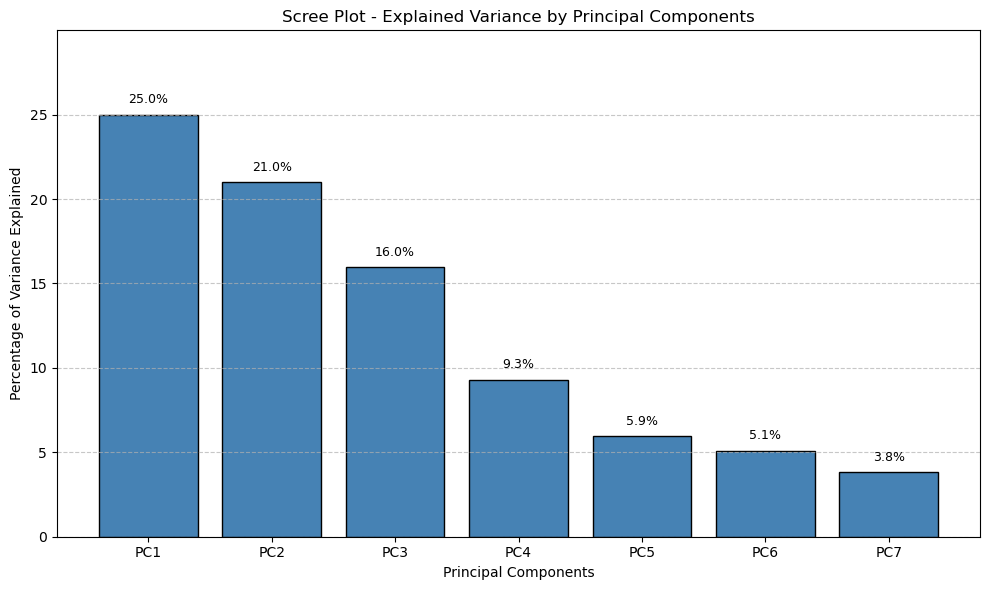

In [20]:
explained_var_pct = pca.explained_variance_ratio_ * 100
pc_labels = [f'PC{i+1}' for i in range(k)]

plt.figure(figsize=(10, 6))
bars = plt.bar(pc_labels, explained_var_pct, color='steelblue', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.title('Scree Plot - Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Variance Explained')
plt.ylim(0, max(explained_var_pct) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


- Cumulative Explained Variance

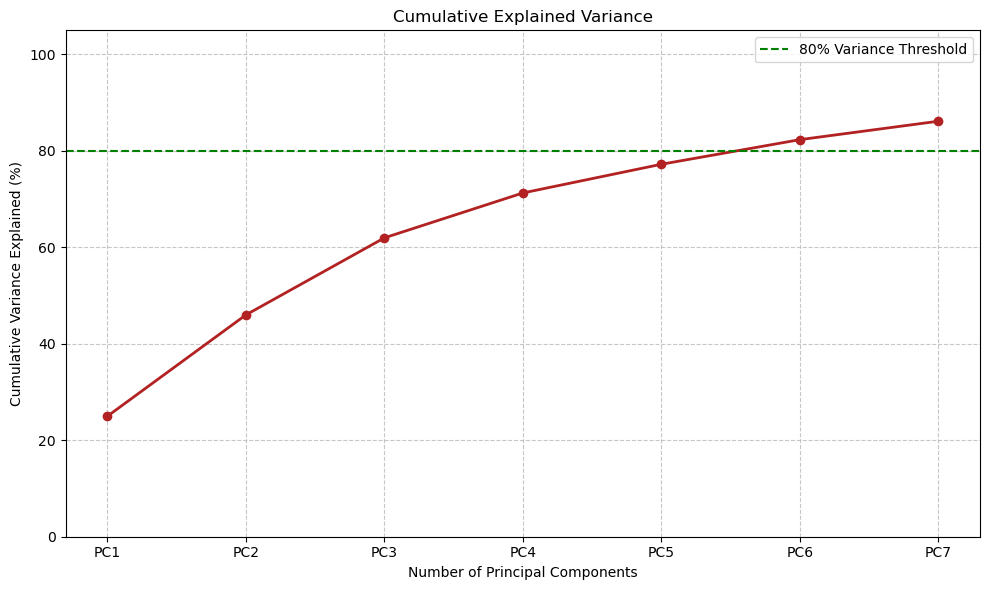

In [46]:
cum_var_pct = np.cumsum(explained_var_pct)

plt.figure(figsize=(10, 6))
plt.plot(pc_labels, cum_var_pct, marker='o', color='firebrick', linewidth=2)
plt.axhline(y=80, color='green', linestyle='--', label='80% Variance Threshold')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


- Scree Plot (Eigen Valies)

Eigenvalues: [4.74918986 3.99164484 3.03502755 1.76787683 1.13045068 0.96944341]
Explained variance ratio: [0.24995728 0.2100865  0.15973824 0.09304612 0.05949738 0.05102332]


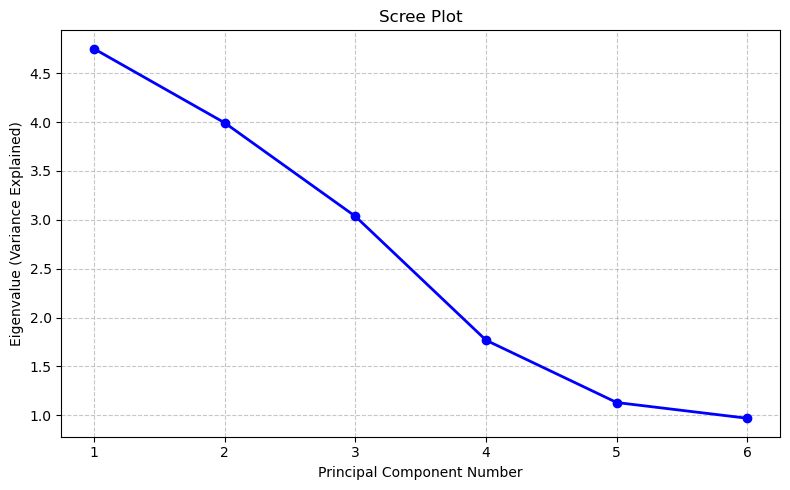

In [24]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)  # Fit PCA here

# Now you can access explained variance attributes
eigenvalues = pca.explained_variance_
explained_var_ratio = pca.explained_variance_ratio_

print("Eigenvalues:", eigenvalues)
print("Explained variance ratio:", explained_var_ratio)


# Assuming you have a fitted PCA object `pca` from sklearn
# Eigenvalues are the explained variance of each PC
eigenvalues = pca.explained_variance_

# Number of components
num_components = len(eigenvalues)
components = np.arange(1, num_components + 1)

plt.figure(figsize=(8, 5))
plt.plot(components, eigenvalues, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component Number')
plt.ylabel('Eigenvalue (Variance Explained)')
plt.xticks(components)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


- PCA Components Heatmap

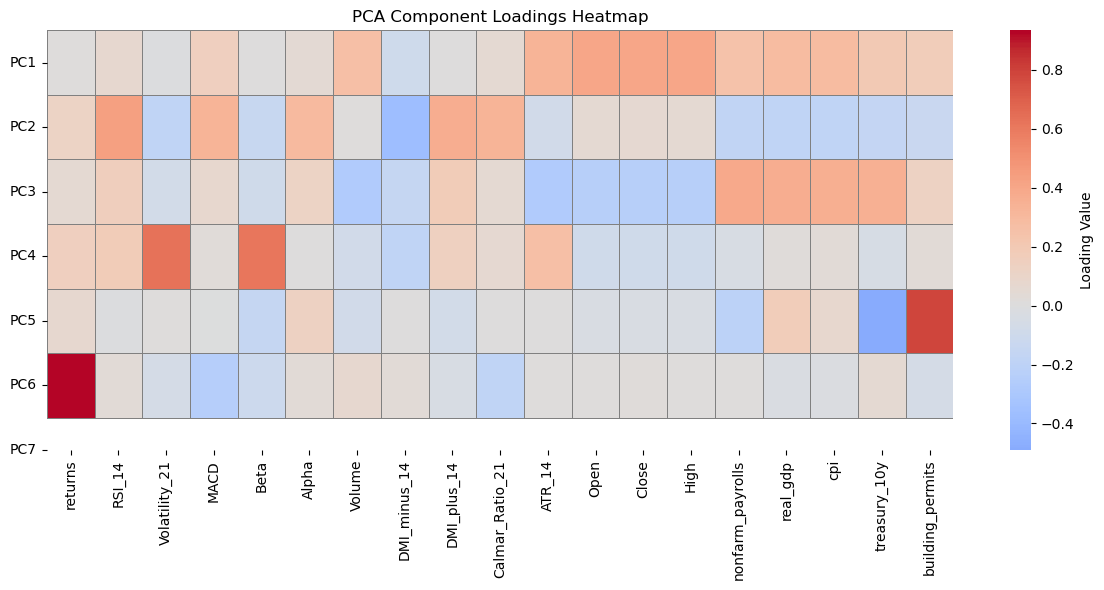

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 'pca' is your fitted PCA object
# 'k' is the number of principal components you retained
# 'features' is the list of original feature names
# 'pc_labels' is a list like [f'PC{i+1}' for i in range(k)]

loadings = pca.components_  # shape: (k, n_features)

plt.figure(figsize=(12, 6))
sns.heatmap(loadings, cmap='coolwarm', center=0,
            yticklabels=pc_labels,
            xticklabels=features,
            cbar_kws={'label': 'Loading Value'},
            linewidths=0.5,
            linecolor='gray')
plt.title('PCA Component Loadings Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [28]:
df_pcs = pd.DataFrame(X_pca, columns=pc_labels)
df_pcs['Date'] = np.repeat(dates, lb * n_assets)[:len(df_pcs)]  # approximate date alignment

df_pcs.to_csv('principal_components_new_1.csv', index=False)
print("Saved principal components to 'principal_components_new_1.csv'")


ValueError: Shape of passed values is (2970880, 6), indices imply (2970880, 7)

In [32]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 7 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])

    weights = weights.values.T
    return weights

weights=PCWeights()

In [34]:
weights[0]

array([ 0.00398188,  0.02097402, -0.00228987,  0.04553058,  0.00091525,
        0.01497459,  0.08149817, -0.03025881,  0.00296625,  0.01820747,
        0.10180791,  0.12452687,  0.12454875,  0.1246018 ,  0.07631256,
        0.08884898,  0.08762928,  0.06301834,  0.05220598])

In [36]:
pca.components_[0]

array([ 0.01287426,  0.06781348, -0.00740363,  0.14721009,  0.00295919,
        0.04841606,  0.26350101, -0.0978332 ,  0.00959051,  0.05886863,
        0.32916673,  0.40262197,  0.40269271,  0.40286424,  0.24673481,
        0.28726772,  0.28332417,  0.20375176,  0.16879309])

In [38]:
NumComponents= 7
feature_cols = [col for col in df.columns if col not in ['Date', 'Ticker']]
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=feature_cols)

eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=False, sharey=True, ylim= (-1,1))

ValueError: Shape of passed values is (6, 19), indices imply (6, 42)

In [40]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

In [42]:
def optimizedPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = eigen_portfolios.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(n_portfolios):
        
        pc_w = pcs[i] / sum(pcs[i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_train_raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric= np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.show()


In [44]:
weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()


    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[0], plot=True)

NameError: name 'stock_tickers' is not defined